In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
df = pd.read_csv("survey_results_public.csv", error_bad_lines=False)


TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'

In [14]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [15]:
df = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]
df = df.rename({"ConvertedComp": "Salary"}, axis=1)
df = df[df["Salary"].notnull()]
df = df.dropna()
df = df[df["Employment"] == "Employed full-time"]
df = df.drop("Employment", axis=1)

In [16]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

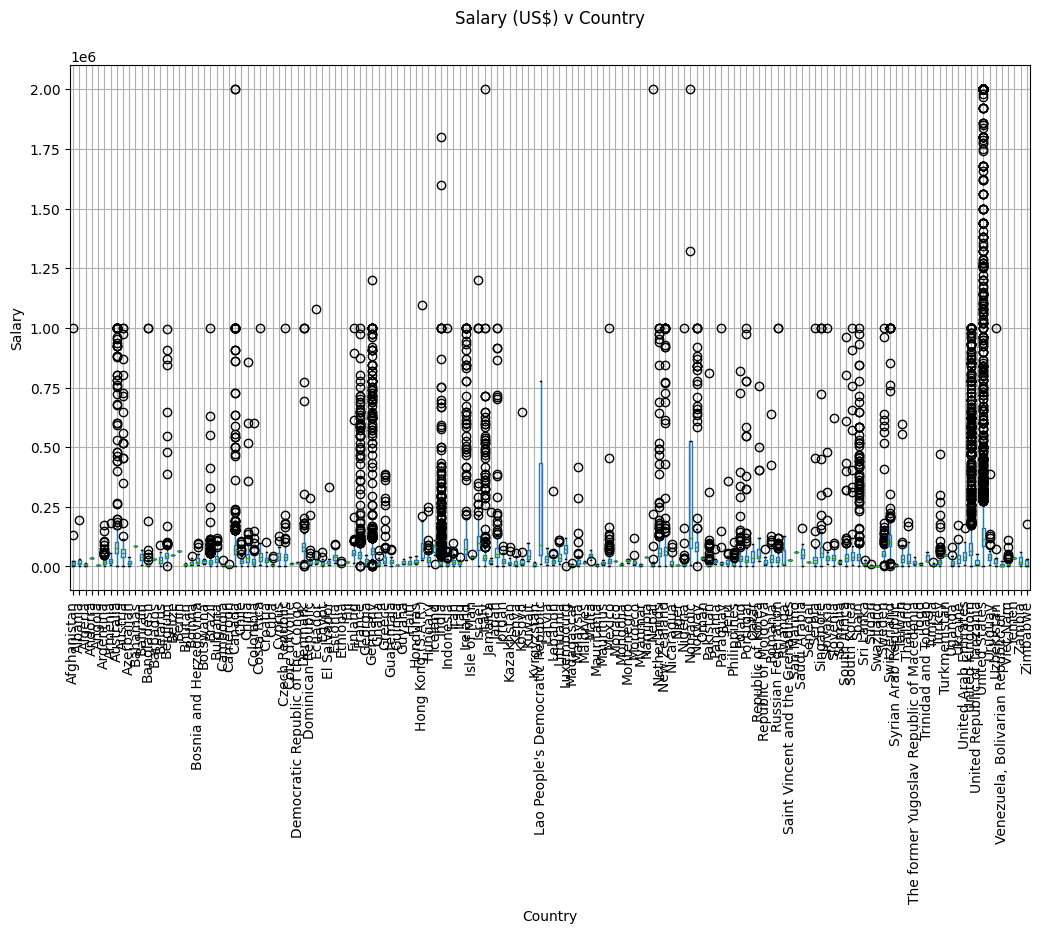

In [17]:
country_map = shorten_categories(df.Country.value_counts(), 400)

fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()


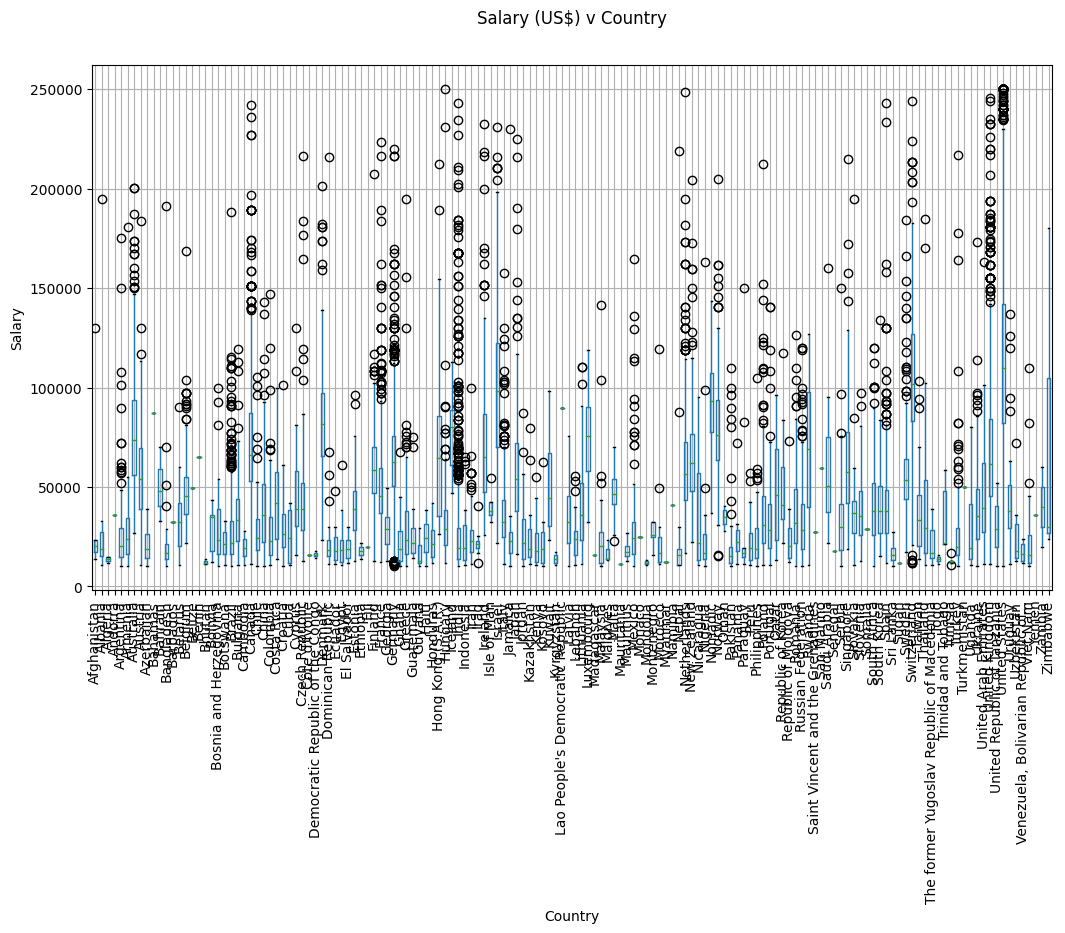

In [18]:
df = df[df["Salary"].between(10000, 250000)]
df = df[df['Country'] != 'Other']

fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()


In [19]:
def clean_experience(x):
    if x ==  'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

df['YearsCodePro'] = df['YearsCodePro'].apply(clean_experience)

def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)

from sklearn.preprocessing import LabelEncoder
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])

le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

X = df.drop("Salary", axis=1)
y = df["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X_train, y_train)

y_pred = random_forest_reg.predict(X_test)
error = mean_squared_error(y_test, y_pred, squared=False)
print("${:,.02f}".format(error))


$29,557.47


In [21]:
import pickle

data = {"model": random_forest_reg, "le_country": le_country, "le_education": le_education}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)


In [22]:
import numpy as np

with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

model_loaded = data["model"]
le_country = data["le_country"]
le_education = data["le_education"]

X_new = np.array([[le_country.transform(['United States'])[0], le_education.transform(['Master’s degree'])[0], 15]])
y_pred = model_loaded.predict(X_new)
print("${:,.02f}".format(y_pred[0]))


$143,079.46


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
